In [1]:
import torch
# monkey-patch modeling_utils safety check
import transformers.modeling_utils as _mu
_mu.check_torch_load_is_safe = lambda *args, **kwargs: None

import glob
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

from utils import paths, read_pickle, write_pickle
from models import CLIPWrapper


/blue/arthur.porto-biocosmos/odobon3.gatech/.conda/envs/biocosmos_o/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPWrapper("bioclip", device)

In [3]:
def display_img_sim(rfpath_sim_tup):

    cos_sim = rfpath_sim_tup[0]
    rfpath_img = rfpath_sim_tup[1]

    ffpath_img = paths["nymph_imgs"] / rfpath_img

    print(f"Cos. Sim. w/ Class Centroid: {cos_sim:.4f}")

    img = Image.open(ffpath_img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")   # turn off axes ticks/labels
    plt.show()

Cos. Sim. w/ Class Centroid: 0.9635


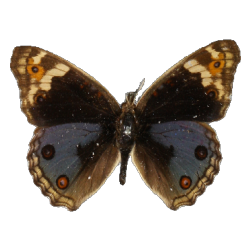

Cos. Sim. w/ Class Centroid: 0.9619


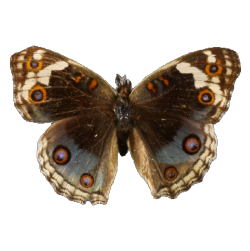

Cos. Sim. w/ Class Centroid: 0.9599


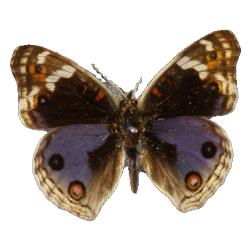

Cos. Sim. w/ Class Centroid: 0.6712


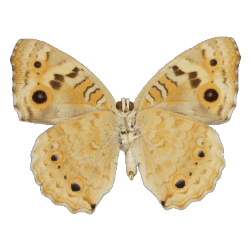

Cos. Sim. w/ Class Centroid: 0.6617


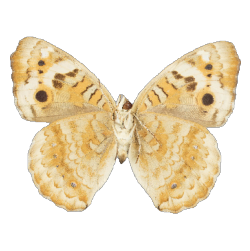

Cos. Sim. w/ Class Centroid: 0.6576


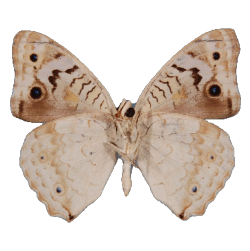

In [6]:
sid = "junonia_orithya"
num_imgs_ends = 3

dpath_imgs_sid = paths["nymph_imgs"] / sid
ffpaths_png = glob.glob(f"{dpath_imgs_sid}/*.png")
rfpaths_png = [png_file.split("images/", 1)[1] for png_file in ffpaths_png]  # full filepath --> relative filepath

imgs = []
for rfpath in rfpaths_png:
    img   = Image.open(paths["nymph_imgs"] / rfpath).convert("RGB")
    img_t = model.img_pp(img)
    imgs.append(img_t)

imgs_tensor = torch.stack(imgs, dim=0)

embs_imgs = model.embed_images(imgs_tensor)
embs_imgs = F.normalize(embs_imgs, dim=-1)

emb_centroid = embs_imgs.mean(dim=0)
emb_centroid = F.normalize(emb_centroid, dim=-1)

rfpath_sim_tups = []

for i in range(len(rfpaths_png)):

    rfpath_png = rfpaths_png[i]
    emb_img = embs_imgs[i]

    cos_sim = torch.dot(emb_img, emb_centroid)

    rfpath_sim_tups.append((cos_sim.item(), rfpath_png))

rfpath_sim_tups.sort(key=lambda t: t[0], reverse=True)

rfpath_sim_tups_closest = rfpath_sim_tups[:num_imgs_ends]
rfpath_sim_tups_furthest = rfpath_sim_tups[-num_imgs_ends:]

for rfpath_sim_tup in rfpath_sim_tups_closest:
    display_img_sim(rfpath_sim_tup)
for rfpath_sim_tup in rfpath_sim_tups_furthest:
    display_img_sim(rfpath_sim_tup)